In [254]:
# import libraries
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import statsmodels.api as sm

In [255]:
# use option to display all columns of dataframe
pd.set_option('display.max_columns', None)

In [256]:
# import the data using URL
#github_url = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2024-25/gws/merged_gw.csv"
#raw_data = pd.read_csv(github_url)

In [257]:
# import the data using local file
raw_data = pd.read_csv("merged_gw.csv")

### Exploratory Data Analysis (EDA)

In [258]:
# inspect the first 10 rows of the data
raw_data.head(10)

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,expected_assists,expected_goal_involvements,expected_goals,expected_goals_conceded,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,modified,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,starts,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,Alex Scott,MID,Bournemouth,1.6,0,0,11,0,12.8,77,0.01,0.01,0.0,1.02,6,1,0,3.6,22.8,2024-08-17T14:00:00Z,62,False,16,0,0,0,0,1,0,4339,1,1,1,0,2,0,0,0,50,False,0,1
1,Carlos Miguel dos Santos Pereira,GK,Nott'm Forest,2.2,0,0,0,0,0.0,427,0.00,0.00,0.0,0.00,6,0,0,0.0,0.0,2024-08-17T14:00:00Z,0,False,3,0,0,0,0,1,0,33324,0,1,1,0,0,0,0,0,45,True,0,1
2,Tomiyasu Takehiro,DEF,Arsenal,0.0,0,0,0,0,0.0,22,0.00,0.00,0.0,0.00,2,0,0,0.0,0.0,2024-08-17T14:00:00Z,0,False,20,0,0,0,0,1,0,8462,0,0,2,0,0,0,0,0,50,True,0,1
3,Malcolm Ebiowei,MID,Crystal Palace,0.0,0,0,0,0,0.0,197,0.00,0.00,0.0,0.00,8,0,0,0.0,0.0,2024-08-18T13:00:00Z,0,False,4,0,0,0,0,1,0,716,0,1,2,0,0,0,0,0,45,False,0,1
4,Ben Brereton Díaz,MID,Southampton,1.0,0,0,-2,0,14.0,584,0.02,0.32,0.3,0.25,5,1,0,3.3,2.6,2024-08-17T14:00:00Z,70,False,15,0,0,0,0,1,0,66244,1,0,1,16,1,0,0,0,55,False,1,1
5,Pau Torres,DEF,Aston Villa,1.9,0,0,17,0,1.9,52,0.01,0.01,0.0,2.46,7,1,0,3.1,29.2,2024-08-17T16:30:00Z,90,False,19,0,0,0,0,1,0,122710,1,2,1,0,2,0,0,0,45,False,0,1
6,Joel Ward,DEF,Crystal Palace,1.9,0,0,0,0,0.0,215,0.00,0.00,0.0,0.00,8,0,0,0.0,0.0,2024-08-18T13:00:00Z,0,False,4,0,0,0,0,1,0,12469,0,1,2,0,0,0,0,0,45,False,0,1
7,Will Lankshear,FWD,Spurs,1.5,0,0,0,0,0.0,609,0.00,0.00,0.0,0.00,10,0,0,0.0,0.0,2024-08-19T19:00:00Z,0,False,11,0,0,0,0,1,0,17747,0,1,1,0,0,0,0,0,45,False,0,1
8,Hwang Hee-chan,MID,Wolves,1.3,0,0,14,0,16.3,550,0.11,0.11,0.0,1.24,2,2,0,2.6,6.0,2024-08-17T14:00:00Z,90,False,1,0,0,0,0,1,0,83019,1,0,2,4,2,0,0,0,65,False,0,1
9,Mikey Moore,MID,Spurs,1.5,0,0,0,0,0.0,610,0.00,0.00,0.0,0.00,10,0,0,0.0,0.0,2024-08-19T19:00:00Z,0,False,11,0,0,0,0,1,0,8413,0,1,1,0,0,0,0,0,45,False,0,1


In [259]:
# check the shape of the data
raw_data.shape

(15663, 42)

In [260]:
# check for null values in the data along the rows
raw_data.isnull().any(axis=1).sum()

0

In [261]:
# check for duplicate values in the data
raw_data.duplicated().sum()

0

In [262]:
# check the data types of the columns and the number of non-null values
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15663 entries, 0 to 15662
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   name                        15663 non-null  object 
 1   position                    15663 non-null  object 
 2   team                        15663 non-null  object 
 3   xP                          15663 non-null  float64
 4   assists                     15663 non-null  int64  
 5   bonus                       15663 non-null  int64  
 6   bps                         15663 non-null  int64  
 7   clean_sheets                15663 non-null  int64  
 8   creativity                  15663 non-null  float64
 9   element                     15663 non-null  int64  
 10  expected_assists            15663 non-null  float64
 11  expected_goal_involvements  15663 non-null  float64
 12  expected_goals              15663 non-null  float64
 13  expected_goals_conceded     156

After inspecting the data and all of the available columns, I will now filter the dataset to include only the relevant columns for my analysis and modelling.

I am focusing on performance metrics that are generally available across football reporting. These include goals scored, assists, clean sheets, yellow cards, red cards, and other standard football statistics. 

The FPL website also provides proprietary metrics such as creativity, influence, and threat, which are specific to their platform and not commonly found in general football datasets. To ensure consistency and broader applicability of the analysis, I am excluding these FPL-specific statistics and only considering universally available performance data. This approach allows for better comparability with external football data sources and enhances the relevance of insights beyond FPL.

In [263]:
# create a list of columns to keep
columns_filter = ['GW', 'round', 'fixture', 'name', 'position', 'team', 'opponent_team', 'starts', 'minutes',
                    'goals_scored', 'expected_goals', 'assists', 'expected_assists', 'expected_goal_involvements',
                    'goals_conceded', 'expected_goals_conceded', 'clean_sheets', 'own_goals',
                    'yellow_cards', 'red_cards', 'penalties_missed', 'saves', 'penalties_saved', 'was_home',
                    'total_points','bonus']

# create a new dataframe with only the relevant columns
df = raw_data[columns_filter].copy()
df.head()

,GW,round,fixture,name,position,team,opponent_team,starts,minutes,goals_scored,expected_goals,assists,expected_assists,expected_goal_involvements,goals_conceded,expected_goals_conceded,clean_sheets,own_goals,yellow_cards,red_cards,penalties_missed,saves,penalties_saved,was_home,total_points,bonus
0,1,1,6,Alex Scott,MID,Bournemouth,16,1,62,0,0.0,0,0.01,0.01,1,1.02,0,0,0,0,0,0,0,False,2,0
1,1,1,6,Carlos Miguel dos Santos Pereira,GK,Nott'm Forest,3,0,0,0,0.0,0,0.00,0.00,0,0.00,0,0,0,0,0,0,0,True,0,0
2,1,1,2,Tomiyasu Takehiro,DEF,Arsenal,20,0,0,0,0.0,0,0.00,0.00,0,0.00,0,0,0,0,0,0,0,True,0,0
3,1,1,8,Malcolm Ebiowei,MID,Crystal Palace,4,0,0,0,0.0,0,0.00,0.00,0,0.00,0,0,0,0,0,0,0,False,0,0
4,1,1,5,Ben Brereton Díaz,MID,Southampton,15,1,70,0,0.3,0,0.02,0.32,1,0.25,0,0,1,0,0,0,0,False,1,0


In [264]:
# inspect the summary statistics of each column of the data
# inspect these to spot any potential outliers or errors  
df.describe(include='all')

,GW,round,fixture,name,position,team,opponent_team,starts,minutes,goals_scored,expected_goals,assists,expected_assists,expected_goal_involvements,goals_conceded,expected_goals_conceded,clean_sheets,own_goals,yellow_cards,red_cards,penalties_missed,saves,penalties_saved,was_home,total_points,bonus
count,15663.000000,15663.000000,15663.000000,15663,15663,15663,15663.000000,15663.000000,15663.000000,15663.000000,15663.000000,15663.000000,15663.000000,15663.000000,15663.000000,15663.000000,15663.000000,15663.000000,15663.000000,15663.000000,15663.000000,15663.000000,15663.000000,15663,15663.000000,15663.000000
unique,NaN,NaN,NaN,756,5,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
top,NaN,NaN,NaN,Alex Scott,MID,Brighton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
freq,NaN,NaN,NaN,23,7090,1043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7851,NaN,NaN
mean,12.286216,12.286216,118.359637,NaN,NaN,NaN,10.506225,0.321650,28.798251,0.042968,0.043653,0.038626,0.028375,0.072023,0.485284,0.474827,0.075273,0.001149,0.064355,0.001979,0.000511,0.092894,0.000511,NaN,1.202260,0.092511
std,6.638185,6.638185,66.459569,NaN,NaN,NaN,5.765637,0.467124,38.509345,0.225453,0.150669,0.210749,0.086722,0.191907,0.945196,0.778667,0.263840,0.035716,0.245393,0.044445,0.022595,0.635328,0.022595,NaN,2.377174,0.455037
min,1.000000,1.000000,1.000000,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,-5.000000,0.000000
25%,7.000000,7.000000,61.000000,NaN,NaN,NaN,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000
50%,12.000000,12.000000,119.000000,NaN,NaN,NaN,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000
75%,18.000000,18.000000,176.500000,NaN,NaN,NaN,15.000000,1.000000,76.000000,0.000000,0.000000,0.000000,0.010000,0.030000,1.000000,0.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.000000,0.000000


All data columns seem to be correct with no major outliers and no unexpected min, max, or mean.

The `total_points` column has a negative number for its minimum value. This is not unusual in FPL (although uncommon), as players receive minus points for various reasons such as yellow/red cards, goals conceded, penalties missed and so this does not seem to be an issue. However, I will inspect the rows of data for any player that has negative points to be certain.

In [265]:
# filter the data to check for negative values in the total_points column, and inspect the top 10 lowest total_points values
# this will help identify any potential errors in the data
df.loc[(df['total_points'] < 0)].sort_values(by='total_points', ascending=True).head(10)

,GW,round,fixture,name,position,team,opponent_team,starts,minutes,goals_scored,expected_goals,assists,expected_assists,expected_goal_involvements,goals_conceded,expected_goals_conceded,clean_sheets,own_goals,yellow_cards,red_cards,penalties_missed,saves,penalties_saved,was_home,total_points,bonus
5290,9,9,83,Harry Clarke,DEF,Ipswich,4,1,68,0,0.00,0,0.02,0.02,4,3.26,0,1,0,1,0,0,0,False,-5,0
8662,14,14,134,Craig Dawson,DEF,Wolves,8,1,90,0,0.00,0,0.00,0.00,4,1.02,0,2,0,0,0,0,0,False,-4,0
8719,14,14,140,Jack Stephens,DEF,Southampton,6,1,38,0,0.00,0,0.00,0.00,5,2.26,0,0,0,1,0,0,0,True,-4,0
10353,16,16,155,Andrew Robertson,DEF,Liverpool,9,1,16,0,0.00,0,0.00,0.00,2,0.11,0,0,0,1,0,0,0,True,-3,0
4799,8,8,71,William Saliba,DEF,Arsenal,3,1,29,0,0.00,0,0.00,0.00,2,0.03,0,0,0,1,0,0,0,False,-3,0
4809,8,8,72,Jaden Philogene,MID,Aston Villa,9,0,29,0,0.04,0,0.00,0.04,0,0.11,0,0,0,1,0,0,0,False,-2,0
5076,8,8,72,Issa Diop,DEF,Fulham,2,0,22,0,0.03,0,0.00,0.03,1,0.17,0,1,1,0,0,0,0,True,-2,0
6328,10,10,97,Edson Álvarez Velázquez,MID,West Ham,16,1,46,0,0.00,0,0.01,0.01,3,1.30,0,0,0,1,0,0,0,False,-2,0
7405,12,12,113,Carlos Baleba,MID,Brighton,3,1,58,0,0.00,0,0.02,0.02,1,0.68,0,0,0,1,0,0,0,False,-2,0
149,1,1,5,Fabian Schär,DEF,Newcastle,17,1,27,0,0.04,0,0.00,0.04,0,0.20,0,0,0,1,0,0,0,True,-2,0


As expected, these players with a negative value for total points have receive negative points for yellow/red cards, own goals, total number of goals conceded. It appears that red cards and own goals are the main reasons for this.

I will now check for any data points where `total_points` has a negative value but none of the negatively impacting columns contain data. These columns include `goals_conceded`, `own_goals`, `yellow_cards`, `red_cards`, and `penalties_missed`. This check will help identify potential errors in cases where a player has negative total points without any recorded negative contributions.

In [266]:
# this will help identify any potential errors in the data
df.loc[(df['total_points'] < 0) & (df['goals_conceded'] < 2) & (df['own_goals'] < 1) & (df['yellow_cards'] < 1) & (df['red_cards'] < 1) & (df['penalties_missed'] < 1)].sort_values(by='total_points')

,GW,round,fixture,name,position,team,opponent_team,starts,minutes,goals_scored,expected_goals,assists,expected_assists,expected_goal_involvements,goals_conceded,expected_goals_conceded,clean_sheets,own_goals,yellow_cards,red_cards,penalties_missed,saves,penalties_saved,was_home,total_points,bonus


From this additional check, I can see that there are no data points where a player has negative `total_points` without any recorded negative contributions. Therefore, I do not identify any issues in the data for negative total points values.

I will now investigate the `total_points` variable, as this will be used as my target variable in modelling

In [267]:
# inspect the counts of the unique total_points values to get an idea of the distribution of the data
df['total_points'].value_counts()

total_points
 0     9135
 1     2717
 2     1780
 3      439
 6      422
 7      202
 5      197
 8      165
 9      146
 4      140
 10      64
 11      45
-1       41
 12      39
 13      34
 15      22
-2       20
 14      16
 16      11
 17       8
 18       4
 20       3
 19       3
-3        2
-4        2
 21       2
 25       1
-5        1
 23       1
 22       1
Name: count, dtype: int64

While this provided a detailed breakdown of the frequency of each unique value, it was not very effective for understanding the overall distribution of points due to the large number of unique values. To address this, I will group the total_points values into broader categories using labels. 

This approach simplifies the data and makes it easier to analyse the overall distribution of player performance. By assigning labels to these ranges, I can now inspect the frequency of each category using value_counts(), which provides a clearer picture of how players' performances are distributed across these broader ranges.

This method allows for a more intuitive understanding of the data and highlights trends in player performance that may not have been apparent when analyzing individual point values.

In [268]:
# create a copy of the total_points column
points = df[["total_points"]].copy()

# create a condition to assign labels to the total_points column based on the ranges of values
points_condition = [(points["total_points"] < 0), (points["total_points"] == 0), (points["total_points"] > 0) & (points["total_points"] <=3), (points["total_points"] > 3) & (points["total_points"] <= 6), (points["total_points"] > 6) & (points["total_points"] <= 9), (points["total_points"] > 9)]

# create a list of labels to assign to the total_points column based on the ranges of values
points_labels = ['Negative Points', '0', '1-3', '4-6', '7-9', '10+']

# use np.select to assign the labels to the total_points column based on the conditions, and create a new column called points_label
points["points_label"] = np.select(points_condition, points_labels)

# inspect the counts of the unique points_label values to get an idea of the distribution of the data
points["points_label"].value_counts()

points_label
0                  9135
1-3                4936
4-6                 759
7-9                 513
10+                 254
Negative Points      66
Name: count, dtype: int64

I can see here that the most common points in the dataset is zero, followed by 1-3. Meaning that it is more common for a player to "blank" in a gameweek (score no points more than appearance points). 

I can also see that it is more common for a player to score over 10 points than to score negative points. 

In [269]:
# inspect the top 10 highest total_points values in a single gameweek
df[['GW', 'name', 'team', 'position', 'goals_scored', 'assists', 'clean_sheets', 'bonus', 'total_points']].sort_values(by='total_points', ascending=False).head(10)

,GW,name,team,position,goals_scored,assists,clean_sheets,bonus,total_points
3224,6,Cole Palmer,Chelsea,MID,4,0,0,3,25
8353,13,Kevin Schade,Brentford,MID,3,1,0,3,23
14660,22,Justin Kluivert,Bournemouth,MID,3,1,0,3,22
10778,17,Mohamed Salah,Liverpool,MID,2,2,0,3,21
15101,23,Dango Ouattara,Bournemouth,MID,3,0,1,3,21
8371,13,Justin Kluivert,Bournemouth,MID,3,0,0,3,20
14102,21,Amad Diallo,Man Utd,MID,3,0,0,3,20
712,2,Noni Madueke,Chelsea,MID,3,0,0,3,20
14301,22,Phil Foden,Man City,MID,2,1,1,3,19
13309,20,Bryan Mbeumo,Brentford,MID,2,1,1,3,19


In [270]:
# find the highest total_points scorers per gameweek

# group by gameweek and find the index of the maximum total_points value
idxmax_per_gw = df.groupby(['GW'])['total_points'].idxmax()

# filter the dataframe by the indices from the maximum total_points values
max_points_per_gw = df.loc[idxmax_per_gw, ['GW','name', 'team', 'position', 'goals_scored', 'assists', 'clean_sheets', 'bonus', 'total_points']].set_index('GW')

# add a background gradient to the total_points column to highlight the highest values
max_points_per_gw.style.background_gradient(cmap='Greens', subset=['total_points'])

,name,team,position,goals_scored,assists,clean_sheets,bonus,total_points
GW,,,,,,,,
1,Mohamed Salah,Liverpool,MID,1,1,1,3,14
2,Noni Madueke,Chelsea,MID,3,0,0,3,20
3,Mohamed Salah,Liverpool,MID,1,2,1,3,17
4,Robert Sánchez,Chelsea,GK,0,0,1,3,15
5,Nicolas Jackson,Chelsea,FWD,2,1,1,3,16
6,Cole Palmer,Chelsea,MID,4,0,0,3,25
7,Michail Antonio,West Ham,FWD,1,3,0,3,18
8,Michael Keane,Everton,DEF,1,0,1,3,14
9,Bryan Mbeumo,Brentford,MID,2,0,0,3,15


In [271]:
# find the top 10 highest total points scorers for the entire season
df.groupby(['name', 'team'])[['total_points']].sum().sort_values(by='total_points', ascending=False).head(10)

,,total_points
name,team,
Mohamed Salah,Liverpool,222
Cole Palmer,Chelsea,167
Alexander Isak,Newcastle,150
Bryan Mbeumo,Brentford,147
Erling Haaland,Man City,143
Chris Wood,Nott'm Forest,137
Justin Kluivert,Bournemouth,121
Matheus Santos Carneiro Da Cunha,Wolves,116
Ollie Watkins,Aston Villa,115


    total_points
GW              
1            811
2            857
3            739
4            814
5            801
6            758
7            873
8            777
9            771
10           775
11           814
12           840
13           828
14           865
15           710
16           819
17           920
18           871
19           834
20           768
21           812
22           851
23           923 



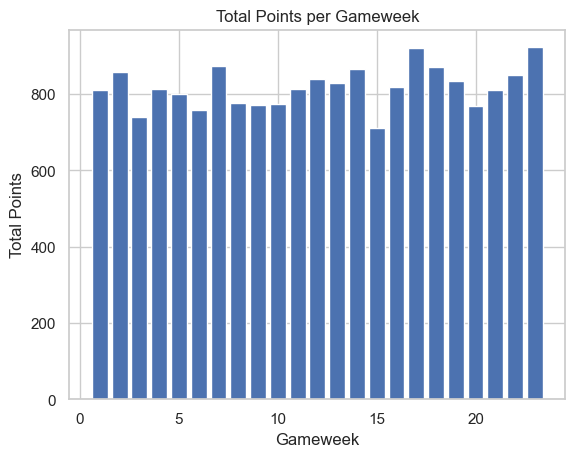

In [272]:
# plot a bar chart of total points per gameweek to inspect how the total_points column differs per gameweek
gameweek_total_points = df.groupby('GW')[['total_points']].sum()

print(gameweek_total_points, "\n")

plt.bar(x=gameweek_total_points.index, height=gameweek_total_points['total_points'])

plt.title('Total Points per Gameweek')
plt.xlabel('Gameweek')
plt.ylabel('Total Points')
plt.show()

Analysing this plot, it appears the total points stays quite consistent on a week-by-week basis. However, there appears to be a slump in the total points for gameweek 15 in comparison to the other gameweeks. I will therefore inspect this further.

It is common for some gameweeks to have less games than others due to postponements in games. Therefore, firstly I will inspect the number of games played each gameweek.

In [273]:
# count the number of unique fixtures per gameweek to see if any gameweek is missing a fixture - all gameweeks should have 10 fixtures in a normal week
df.groupby('GW')[['fixture']].nunique().rename(columns={'fixture' : 'unique_fixtures'})

,unique_fixtures
GW,
1,10
2,10
3,10
4,10
5,10
6,10
7,10
8,10
9,10


We can see that gameweek 15 does in fact have less fixtures than other weeks, explaining the difference in total_points for that gameweek. Looking into this further, it is due to one of the fixtures being postponed due to weather conditions, so this is expected to be seen in the data.

                total_points
team                        
Liverpool               1257
Arsenal                 1119
Newcastle               1108
Bournemouth             1096
Nott'm Forest           1083
Man City                1049
Chelsea                 1023
Spurs                    979
Brighton                 956
Brentford                954
Fulham                   947
Man Utd                  922
Crystal Palace           916
Aston Villa              892
Everton                  859
West Ham                 825
Wolves                   804
Leicester                714
Ipswich                  691
Southampton              637 



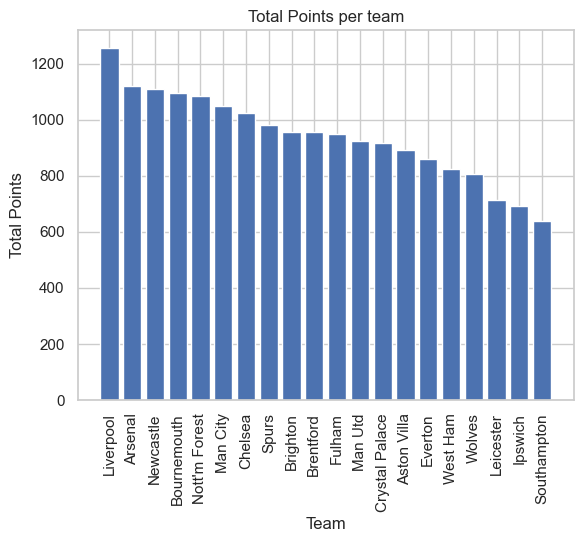

In [274]:
# plot and inspect the total points per team
gameweek_total_points = df.groupby('team')[['total_points']].sum().sort_values(by='total_points', ascending=False)

print(gameweek_total_points, "\n")

plt.bar(x=gameweek_total_points.index, height=gameweek_total_points['total_points'])

plt.title('Total Points per team')
plt.xlabel('Team')
plt.ylabel('Total Points')
plt.xticks(rotation=90)
plt.show()

### Data Cleaning/Preprocessing

The `opponent_team` column in the dataset currently contains only the ID of the opposing team. From my research of the data source, I know that these IDs are assigned based on the alphabetical order of team names (e.g., Arsenal = 1, Aston Villa = 2, Bournemouth = 3, etc.).

To make the data more readable and interpretable, I will map the IDs to the full team names.  

In [275]:
# Create a team ID, team Name dictionary using a dictionary comprehension and enumerate function
# Enumerate function prints the values and their index, starting from 0 unless specified (here it is specified to start at 1)
teams_id_dict = {id : team for id, team in enumerate(df['team'].sort_values().unique(), 1)}
teams_id_dict

{1: 'Arsenal',
 2: 'Aston Villa',
 3: 'Bournemouth',
 4: 'Brentford',
 5: 'Brighton',
 6: 'Chelsea',
 7: 'Crystal Palace',
 8: 'Everton',
 9: 'Fulham',
 10: 'Ipswich',
 11: 'Leicester',
 12: 'Liverpool',
 13: 'Man City',
 14: 'Man Utd',
 15: 'Newcastle',
 16: "Nott'm Forest",
 17: 'Southampton',
 18: 'Spurs',
 19: 'West Ham',
 20: 'Wolves'}

In [276]:
# Create a new column which gives the name of the opponent team, rather than using the ID
df['opponent'] = df['opponent_team'].map(teams_id_dict)

In [277]:
# rename the columns
df = df.rename(columns={'goals_scored' : 'goals',
                        'expected_goals' : 'xG',
                        'expected_assists' : 'xA',
                        'expected_goal_involvements' : 'xGI',
                        'goals_conceded' : 'GC',
                        'expected_goals_conceded' : 'xGC',
                        'total_points' : 'points'})

**Removing Zero Minute Data Points**

There are multiple data points where a player has 0 minutes played. These instances do not contribute to a player's performance metrics, as they do not count as an appearance and have no impact on key predictive features like goals, expected goals (xG), or total points.

Including these records would introduce noise into the dataset without providing any useful information for the regression model. By filtering out players with 0 minutes, I ensure that the model is trained only on meaningful data where a player's performance can be evaluated based on actual game time.

In [278]:
# remove rows where the player played no minutes
df = df.loc[(df['minutes'] > 0)].reset_index(drop=True).copy()

In [279]:
# save dataframe to csv to be used in fdr rating notebook
#df.to_csv('cleaned_data.csv', index=False)

**Splitting Data into Training and Testing**

To avoid data leakage, I will split the dataset into training and testing sets based on gameweeks now rather than using a random split just before modelling. This is because I will be calculating aggregate statistics for the entire season so far and using this in my modelling. By splitting the data into training and testing datasets now, and based on the gameweeks rather than random split, it ensures that the training dataset does not contain information derived from future gameweeks, which would not be available in a real-world scenario.

*Why is this necessary?*
1. Avoiding Future Data Leakage
    * Calculating aggregated statistics (e.g., goals per game, xG per game) using both training and test data would mean that future data influenced past data. This would not be possible in a real-world scenario and could lead to overly optimistic model performance.
    * By splitting the data first, we ensure that any aggregated statistics are only calculated using past data, preventing information from the test set from leaking into the training set.

2. Mimicking Real-World Data Availability
    * In practice, when making predictions for future fixtures, we only have access to historical data.
    * Splitting by gameweek ensures that the model is trained only on past gameweeks and is tested on future gameweeks, simulating how the model would be used in reality.

*How is the data split?*
* 80/20 training/test split
* This ensures that all training data comes from earlier gameweeks, and all test data comes from later gameweeks, maintaining the correct temporal structure of the data.

By performing the split before calculating aggregated statistics, we eliminate data leakage and ensure a more reliable evaluation of the model’s predictive power on unseen data.

In [280]:
max_gameweek = df['GW'].max()
print("max_gameweek:", max_gameweek)

min_gameweek = df['GW'].min()
print("min_gameweek:", min_gameweek)

training_gameweek_threshold = round(max_gameweek * 0.8)
print("training_gameweek_threshold:", training_gameweek_threshold)

max_gameweek: 23
min_gameweek: 1
training_gameweek_threshold: 18


In [281]:
training_df = df.loc[(df['GW'] <= training_gameweek_threshold)].copy()
testing_df = df.loc[(df['GW'] > training_gameweek_threshold)].copy()

### Teams Stats Tables

To enhance the predictive power of the model, I will calculate **aggregated team statistics** on both the training dataset and the entire dataset. As mentioned, the stats are calculated separately for the training dataset to avoid target leakage. These aggregated statistics provide a summary of a team's performance over the season so far and are used as features in the model to help predict future Fantasy Premier League (FPL) points.

Player performance does not exist in isolation — it depends on their team’s ability to create and convert chances, defend well, and win matches. Including team statistics ensures that the model accounts for how a player's team contributes to their FPL points.

Aggregated statistics are only calculated using the training dataset to ensure that no future data influences the model. This prevents data leakage, ensuring the model only has access to historical data when making predictions, just like it would in a real-world scenario.

In [282]:
training_df.head()

,GW,round,fixture,name,position,team,opponent_team,starts,minutes,goals,xG,assists,xA,xGI,GC,xGC,clean_sheets,own_goals,yellow_cards,red_cards,penalties_missed,saves,penalties_saved,was_home,points,bonus,opponent
0,1,1,6,Alex Scott,MID,Bournemouth,16,1,62,0,0.0,0,0.01,0.01,1,1.02,0,0,0,0,0,0,0,False,2,0,Nott'm Forest
1,1,1,5,Ben Brereton Díaz,MID,Southampton,15,1,70,0,0.3,0,0.02,0.32,1,0.25,0,0,1,0,0,0,0,False,1,0,Newcastle
2,1,1,7,Pau Torres,DEF,Aston Villa,19,1,90,0,0.0,0,0.01,0.01,1,2.46,0,0,0,0,0,0,0,False,2,0,West Ham
3,1,1,2,Hwang Hee-chan,MID,Wolves,1,1,90,0,0.0,0,0.11,0.11,2,1.24,0,0,0,0,0,0,0,False,2,0,Arsenal
4,1,1,2,João Victor Gomes da Silva,MID,Wolves,1,1,83,0,0.0,0,0.02,0.02,2,1.24,0,0,1,0,0,0,0,False,1,0,Arsenal


**Aggregating Team-Level Statistics and Deriving Opponent Stats**

To analyze team performance at a per-fixture level, I will aggregate key statistics from the dataset, specifically the number of goals scored, expected goals (xG), and whether the team played at home.

After obtaining these aggregated team statistics, I then merge the dataframe with itself to retrieve the opponent’s statistics for the same fixture. This self-join is allows me to extract the opponent’s goals and xG as separate columns. These represent the `goals conceded (GC)` and `expected goals conceded (xGC)` for the team in focus.  

This transformed dataset provides a structured way to analyze both a team's attacking and defensive performances in each fixture, forming the foundation for further predictive modeling.  


In [283]:
# group the data by gameweek, round, fixture, team and opponent and calculate aggregate statistics for goals, xG and whether the fixture was home or away
gw_team_grouped_train = training_df.groupby(['GW', 'round', 'fixture', 'team', 'opponent']).aggregate({'goals': 'sum',
                                                                                        'xG': 'sum',
                                                                                        'was_home': 'max'}).reset_index()

# repeat for entire dataset
gw_team_grouped_all = df.groupby(['GW', 'round', 'fixture', 'team', 'opponent']).aggregate({'goals': 'sum',
                                                                                        'xG': 'sum',
                                                                                        'was_home': 'max'}).reset_index()

gw_team_grouped_train

,GW,round,fixture,team,opponent,goals,xG,was_home
0,1,1,1,Fulham,Man Utd,0,0.44,False
1,1,1,1,Man Utd,Fulham,1,2.43,True
2,1,1,2,Arsenal,Wolves,2,1.26,True
3,1,1,2,Wolves,Arsenal,0,0.48,False
4,1,1,3,Brighton,Everton,3,1.44,False
...,...,...,...,...,...,...,...,...
353,18,18,178,Spurs,Nott'm Forest,0,0.91,False
354,18,18,179,Southampton,West Ham,0,1.41,True
355,18,18,179,West Ham,Southampton,1,1.82,False
356,18,18,180,Man Utd,Wolves,0,0.45,False


In [284]:
# join the grouped df with itself to get the stats of the opponent team, which will give the goals conceded, xGC, etc. of the team in question
gw_team_stats_train = pd.merge(gw_team_grouped_train,
                         gw_team_grouped_train,
                         how='left',
                         left_on=['GW', 'round', 'fixture', 'team'],
                         right_on=['GW', 'round', 'fixture', 'opponent'],
                         suffixes=('', '_opponent'))

# repeat for the entire dataset
gw_team_stats_all = pd.merge(gw_team_grouped_all,
                         gw_team_grouped_all,
                         how='left',
                         left_on=['GW', 'round', 'fixture', 'team'],
                         right_on=['GW', 'round', 'fixture', 'opponent'],
                         suffixes=('', '_opponent'))

gw_team_stats_train

,GW,round,fixture,team,opponent,goals,xG,was_home,team_opponent,opponent_opponent,goals_opponent,xG_opponent,was_home_opponent
0,1,1,1,Fulham,Man Utd,0,0.44,False,Man Utd,Fulham,1,2.43,True
1,1,1,1,Man Utd,Fulham,1,2.43,True,Fulham,Man Utd,0,0.44,False
2,1,1,2,Arsenal,Wolves,2,1.26,True,Wolves,Arsenal,0,0.48,False
3,1,1,2,Wolves,Arsenal,0,0.48,False,Arsenal,Wolves,2,1.26,True
4,1,1,3,Brighton,Everton,3,1.44,False,Everton,Brighton,0,0.46,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,18,18,178,Spurs,Nott'm Forest,0,0.91,False,Nott'm Forest,Spurs,1,1.12,True
354,18,18,179,Southampton,West Ham,0,1.41,True,West Ham,Southampton,1,1.82,False
355,18,18,179,West Ham,Southampton,1,1.82,False,Southampton,West Ham,0,1.41,True
356,18,18,180,Man Utd,Wolves,0,0.45,False,Wolves,Man Utd,2,0.86,True


In [285]:
# slice the merged dataframe to keep only the relevant columns
gw_team_stats_sliced_train = gw_team_stats_train[['GW', 'round', 'fixture', 'team', 'goals','xG', 'was_home', 'goals_opponent', 'xG_opponent', 'opponent']].copy()

gw_team_stats_sliced_all = gw_team_stats_all[['GW', 'round', 'fixture', 'team', 'goals','xG', 'was_home', 'goals_opponent', 'xG_opponent', 'opponent']].copy()

# rename the columns to make them more readable
team_stats_per_gw_train = gw_team_stats_sliced_train.rename(columns={'goals_opponent': 'GC',
                                                         'xG_opponent': 'xGC'})

team_stats_per_gw_all = gw_team_stats_sliced_all.rename(columns={'goals_opponent': 'GC',
                                                         'xG_opponent': 'xGC'})

team_stats_per_gw_train

,GW,round,fixture,team,goals,xG,was_home,GC,xGC,opponent
0,1,1,1,Fulham,0,0.44,False,1,2.43,Man Utd
1,1,1,1,Man Utd,1,2.43,True,0,0.44,Fulham
2,1,1,2,Arsenal,2,1.26,True,0,0.48,Wolves
3,1,1,2,Wolves,0,0.48,False,2,1.26,Arsenal
4,1,1,3,Brighton,3,1.44,False,0,0.46,Everton
...,...,...,...,...,...,...,...,...,...,...
353,18,18,178,Spurs,0,0.91,False,1,1.12,Nott'm Forest
354,18,18,179,Southampton,0,1.41,True,1,1.82,West Ham
355,18,18,179,West Ham,1,1.82,False,0,1.41,Southampton
356,18,18,180,Man Utd,0,0.45,False,2,0.86,Wolves


In [286]:
# create a new column for clean sheets
team_stats_per_gw_train['CS'] = np.where(team_stats_per_gw_train['GC'] == 0, 1, 0)
team_stats_per_gw_all['CS'] = np.where(team_stats_per_gw_all['GC'] == 0, 1, 0)

# create a new column for whether they won the match or not
team_stats_per_gw_train['match_won'] = np.where(team_stats_per_gw_train['goals'] > team_stats_per_gw_train['GC'], 1, 0)
team_stats_per_gw_all['match_won'] = np.where(team_stats_per_gw_all['goals'] > team_stats_per_gw_all['GC'], 1, 0)

team_stats_per_gw_train

,GW,round,fixture,team,goals,xG,was_home,GC,xGC,opponent,CS,match_won
0,1,1,1,Fulham,0,0.44,False,1,2.43,Man Utd,0,0
1,1,1,1,Man Utd,1,2.43,True,0,0.44,Fulham,1,1
2,1,1,2,Arsenal,2,1.26,True,0,0.48,Wolves,1,1
3,1,1,2,Wolves,0,0.48,False,2,1.26,Arsenal,0,0
4,1,1,3,Brighton,3,1.44,False,0,0.46,Everton,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
353,18,18,178,Spurs,0,0.91,False,1,1.12,Nott'm Forest,0,0
354,18,18,179,Southampton,0,1.41,True,1,1.82,West Ham,0,0
355,18,18,179,West Ham,1,1.82,False,0,1.41,Southampton,1,1
356,18,18,180,Man Utd,0,0.45,False,2,0.86,Wolves,0,0


Find the total aggregated statistics for the entire season so far, not on a gameweek-basis

In [287]:
# group the data by team and aggregate the statistics to find entire season totals
team_total_stats_train = team_stats_per_gw_train.groupby('team').agg({'goals' : 'sum',
                                                         'xG' : 'sum',
                                                         'GC' : 'sum',
                                                         'xGC' : 'sum',
                                                         'CS' : 'sum',
                                                         'fixture' : 'count',
                                                         'match_won' : 'sum'}).reset_index()

team_total_stats_all = team_stats_per_gw_all.groupby('team').agg({'goals' : 'sum',
                                                         'xG' : 'sum',
                                                         'GC' : 'sum',
                                                         'xGC' : 'sum',
                                                         'CS' : 'sum',
                                                         'fixture' : 'count',
                                                         'match_won' : 'sum'}).reset_index()

team_total_stats_train = team_total_stats_train.rename(columns={'fixture' : 'games_played',
                                                    'match_won' : 'games_won'})

team_total_stats_all = team_total_stats_all.rename(columns={'fixture' : 'games_played',
                                                    'match_won' : 'games_won'})

team_total_stats_train

,team,goals,xG,GC,xGC,CS,games_played,games_won
0,Arsenal,34,32.28,16,16.20,7,18,10
1,Aston Villa,25,28.16,29,23.38,2,18,8
2,Bournemouth,27,35.31,21,22.97,4,18,8
3,Brentford,31,27.46,31,30.60,3,18,6
4,Brighton,26,25.69,25,27.87,4,18,6
5,Chelsea,38,36.48,21,25.70,4,18,10
6,Crystal Palace,17,24.57,24,27.04,6,18,4
7,Everton,13,16.85,22,23.08,7,17,3
8,Fulham,25,24.52,22,21.69,3,18,7
9,Ipswich,15,16.51,32,38.17,1,18,1


**Calculate per game statistics**

As seen previously, not all teams have played the same amount of games. To make the statistics comparable, I will calculate per-game statistics to estimate performance.

In [288]:
# create a list of columns to calculate per game statistics
stats_columns = ['goals', 'xG', 'GC', 'xGC', 'CS', 'games_won']

# calculate the per game statistics by dividing the total statistics by the number of games played
for column in stats_columns:
    team_total_stats_train[f'{column}_pg'] = round(team_total_stats_train[column] / team_total_stats_train['games_played'], 2)
    team_total_stats_all[f'{column}_pg'] = round(team_total_stats_all[column] / team_total_stats_all['games_played'], 2)

team_total_stats_train

,team,goals,xG,GC,xGC,CS,games_played,games_won,goals_pg,xG_pg,GC_pg,xGC_pg,CS_pg,games_won_pg
0,Arsenal,34,32.28,16,16.20,7,18,10,1.89,1.79,0.89,0.90,0.39,0.56
1,Aston Villa,25,28.16,29,23.38,2,18,8,1.39,1.56,1.61,1.30,0.11,0.44
2,Bournemouth,27,35.31,21,22.97,4,18,8,1.50,1.96,1.17,1.28,0.22,0.44
3,Brentford,31,27.46,31,30.60,3,18,6,1.72,1.53,1.72,1.70,0.17,0.33
4,Brighton,26,25.69,25,27.87,4,18,6,1.44,1.43,1.39,1.55,0.22,0.33
5,Chelsea,38,36.48,21,25.70,4,18,10,2.11,2.03,1.17,1.43,0.22,0.56
6,Crystal Palace,17,24.57,24,27.04,6,18,4,0.94,1.36,1.33,1.50,0.33,0.22
7,Everton,13,16.85,22,23.08,7,17,3,0.76,0.99,1.29,1.36,0.41,0.18
8,Fulham,25,24.52,22,21.69,3,18,7,1.39,1.36,1.22,1.20,0.17,0.39
9,Ipswich,15,16.51,32,38.17,1,18,1,0.83,0.92,1.78,2.12,0.06,0.06


In [289]:
# # extract only the per game columns
# per_game_totals_columns_train = [column for column in team_total_stats_train.columns if '_pg' in column]
# per_game_totals_columns_all = [column for column in team_total_stats_all.columns if '_pg' in column]

# # create a new dataframe with only the per game statistics
# per_game_totals_train = team_total_stats_train[per_game_totals_columns_train].copy()
# per_game_totals_train = per_game_totals_train.set_index(team_total_stats_train['team'])

# per_game_totals_all = team_total_stats_all[per_game_totals_columns_all].copy()
# per_game_totals_all = per_game_totals_all.set_index(team_total_stats_all['team'])

# per_game_totals_train

### Player Stats Tables

Similar to team stats, I will find aggregate statistics per player to enhance the predictive power of the model as it will provide it with a summary of a player's performance over the season so far.

In [290]:
# create a copy of the training dataframe to use for the players data, which will be used to create the player statistics
fpl_players_train = training_df.copy()

# repeat for entire dataset
fpl_players_all = df.copy()

fpl_players_train.head()

,GW,round,fixture,name,position,team,opponent_team,starts,minutes,goals,xG,assists,xA,xGI,GC,xGC,clean_sheets,own_goals,yellow_cards,red_cards,penalties_missed,saves,penalties_saved,was_home,points,bonus,opponent
0,1,1,6,Alex Scott,MID,Bournemouth,16,1,62,0,0.0,0,0.01,0.01,1,1.02,0,0,0,0,0,0,0,False,2,0,Nott'm Forest
1,1,1,5,Ben Brereton Díaz,MID,Southampton,15,1,70,0,0.3,0,0.02,0.32,1,0.25,0,0,1,0,0,0,0,False,1,0,Newcastle
2,1,1,7,Pau Torres,DEF,Aston Villa,19,1,90,0,0.0,0,0.01,0.01,1,2.46,0,0,0,0,0,0,0,False,2,0,West Ham
3,1,1,2,Hwang Hee-chan,MID,Wolves,1,1,90,0,0.0,0,0.11,0.11,2,1.24,0,0,0,0,0,0,0,False,2,0,Arsenal
4,1,1,2,João Victor Gomes da Silva,MID,Wolves,1,1,83,0,0.0,0,0.02,0.02,2,1.24,0,0,1,0,0,0,0,False,1,0,Arsenal


In [291]:
# create a new column to indicate whether or not the player played in the match
fpl_players_train['appearance'] = np.where(fpl_players_train['minutes'] > 0, 1, 0)

fpl_players_all['appearance'] = np.where(fpl_players_all['minutes'] > 0, 1, 0)

In [292]:
# create a list of columns to calculate aggregate statistics for each player
player_fields = ['appearance','starts','minutes','goals','xG', 'assists','xA', 'GC','xGC', 'clean_sheets', 'own_goals',
                 'yellow_cards', 'red_cards', 'penalties_missed','saves', 'penalties_saved', 'bonus','points']

In [293]:
# group the data by player and aggregate the statistics to find entire season totals
player_stats_train = fpl_players_train.groupby(['name', 'team', 'position'])[player_fields].sum().reset_index()
player_stats_all = fpl_players_all.groupby(['name', 'team', 'position'])[player_fields].sum().reset_index()

player_stats_train.head(10)

,name,team,position,appearance,starts,minutes,goals,xG,assists,xA,GC,xGC,clean_sheets,own_goals,yellow_cards,red_cards,penalties_missed,saves,penalties_saved,bonus,points
0,Aaron Cresswell,West Ham,DEF,6,0,50,0,0.03,0,0.10,0,1.51,0,0,1,0,0,0,0,0,5
1,Aaron Ramsdale,Southampton,GK,11,11,990,0,0.00,0,0.01,20,23.18,2,0,1,0,0,42,0,5,38
2,Aaron Wan-Bissaka,West Ham,DEF,17,16,1444,2,0.76,1,1.28,28,28.32,3,0,0,0,0,0,0,6,58
3,Abdoulaye Doucouré,Everton,MID,15,14,1162,0,0.61,0,0.48,15,17.73,7,0,0,0,0,0,0,0,35
4,Abdul Fatawu,Leicester,MID,11,6,576,0,0.41,2,1.42,14,11.00,0,0,0,0,0,0,0,3,26
5,Adam Armstrong,Southampton,FWD,15,12,1014,2,3.09,2,0.52,20,23.62,2,0,4,0,1,0,0,2,36
6,Adam Lallana,Southampton,MID,9,5,315,0,0.15,2,0.48,5,5.69,0,0,4,0,0,0,0,1,12
7,Adam Smith,Bournemouth,DEF,17,12,1032,0,0.60,0,0.10,13,12.51,3,0,4,0,0,0,0,0,34
8,Adam Webster,Brighton,DEF,3,2,78,0,0.00,0,0.03,4,3.95,0,0,0,0,0,0,0,0,1
9,Adam Wharton,Crystal Palace,MID,8,8,621,0,0.22,0,0.60,9,9.39,1,0,0,0,0,0,0,0,15


Like with teams, players also have not played the equal number of games so far this season. To make statistics comparable for unequal games, I will calculate per game statistics. 

In [294]:
# create a list of columns to calculate per game statistics
per_game_cols = ["starts", "minutes", "goals", "xG", "assists", "xA", "GC", "xGC", "clean_sheets", "own_goals", "yellow_cards",
                 "red_cards", "penalties_missed", "saves", "penalties_saved", "points"]

for column in per_game_cols:
    player_stats_train[column + "_pg"] = round((player_stats_train[column]/player_stats_train["appearance"]), 2)
    player_stats_all[column + "_pg"] = round((player_stats_all[column]/player_stats_all["appearance"]), 2)

player_stats_train.head()

,name,team,position,appearance,starts,minutes,goals,xG,assists,xA,GC,xGC,clean_sheets,own_goals,yellow_cards,red_cards,penalties_missed,saves,penalties_saved,bonus,points,starts_pg,minutes_pg,goals_pg,xG_pg,assists_pg,xA_pg,GC_pg,xGC_pg,clean_sheets_pg,own_goals_pg,yellow_cards_pg,red_cards_pg,penalties_missed_pg,saves_pg,penalties_saved_pg,points_pg
0,Aaron Cresswell,West Ham,DEF,6,0,50,0,0.03,0,0.10,0,1.51,0,0,1,0,0,0,0,0,5,0.00,8.33,0.00,0.00,0.00,0.02,0.00,0.25,0.00,0.0,0.17,0.0,0.0,0.00,0.0,0.83
1,Aaron Ramsdale,Southampton,GK,11,11,990,0,0.00,0,0.01,20,23.18,2,0,1,0,0,42,0,5,38,1.00,90.00,0.00,0.00,0.00,0.00,1.82,2.11,0.18,0.0,0.09,0.0,0.0,3.82,0.0,3.45
2,Aaron Wan-Bissaka,West Ham,DEF,17,16,1444,2,0.76,1,1.28,28,28.32,3,0,0,0,0,0,0,6,58,0.94,84.94,0.12,0.04,0.06,0.08,1.65,1.67,0.18,0.0,0.00,0.0,0.0,0.00,0.0,3.41
3,Abdoulaye Doucouré,Everton,MID,15,14,1162,0,0.61,0,0.48,15,17.73,7,0,0,0,0,0,0,0,35,0.93,77.47,0.00,0.04,0.00,0.03,1.00,1.18,0.47,0.0,0.00,0.0,0.0,0.00,0.0,2.33
4,Abdul Fatawu,Leicester,MID,11,6,576,0,0.41,2,1.42,14,11.00,0,0,0,0,0,0,0,3,26,0.55,52.36,0.00,0.04,0.18,0.13,1.27,1.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,2.36


In [295]:
# rename the columns to make them more readable
player_stats_train = player_stats_train.rename(columns={'appearance' : 'total_appearances',
                                            'starts' : 'total_starts',
                                            'minutes' : 'total_minutes',
                                            'goals' : 'total_goals',
                                            'xG' : 'total_xG',
                                            'assists' : 'total_assists',
                                            'xA' : 'total_xA',
                                            'GC' : 'total_GC',
                                            'xGC' : 'total_xGC',
                                            'clean_sheets' : 'total_CS',
                                            'own_goals' : 'total_own_goals',
                                            'yellow_cards' : 'total_yellow_cards',
                                            'red_cards' : 'total_red_cards',
                                            'penalties_missed' : 'total_penalties_missed',
                                            'saves' : 'total_saves',
                                            'penalties_saved' : 'total_penalties_saved',
                                            'bonus' : 'total_bonus',
                                            'points' : 'total_points',
                                            'clean_sheets_pg' : 'CS_pg'})

player_stats_all = player_stats_all.rename(columns={'appearance' : 'total_appearances',
                                            'starts' : 'total_starts',
                                            'minutes' : 'total_minutes',
                                            'goals' : 'total_goals',
                                            'xG' : 'total_xG',
                                            'assists' : 'total_assists',
                                            'xA' : 'total_xA',
                                            'GC' : 'total_GC',
                                            'xGC' : 'total_xGC',
                                            'clean_sheets' : 'total_CS',
                                            'own_goals' : 'total_own_goals',
                                            'yellow_cards' : 'total_yellow_cards',
                                            'red_cards' : 'total_red_cards',
                                            'penalties_missed' : 'total_penalties_missed',
                                            'saves' : 'total_saves',
                                            'penalties_saved' : 'total_penalties_saved',
                                            'bonus' : 'total_bonus',
                                            'points' : 'total_points',
                                            'clean_sheets_pg' : 'CS_pg'})

player_stats_train.head()

,name,team,position,total_appearances,total_starts,total_minutes,total_goals,total_xG,total_assists,total_xA,total_GC,total_xGC,total_CS,total_own_goals,total_yellow_cards,total_red_cards,total_penalties_missed,total_saves,total_penalties_saved,total_bonus,total_points,starts_pg,minutes_pg,goals_pg,xG_pg,assists_pg,xA_pg,GC_pg,xGC_pg,CS_pg,own_goals_pg,yellow_cards_pg,red_cards_pg,penalties_missed_pg,saves_pg,penalties_saved_pg,points_pg
0,Aaron Cresswell,West Ham,DEF,6,0,50,0,0.03,0,0.10,0,1.51,0,0,1,0,0,0,0,0,5,0.00,8.33,0.00,0.00,0.00,0.02,0.00,0.25,0.00,0.0,0.17,0.0,0.0,0.00,0.0,0.83
1,Aaron Ramsdale,Southampton,GK,11,11,990,0,0.00,0,0.01,20,23.18,2,0,1,0,0,42,0,5,38,1.00,90.00,0.00,0.00,0.00,0.00,1.82,2.11,0.18,0.0,0.09,0.0,0.0,3.82,0.0,3.45
2,Aaron Wan-Bissaka,West Ham,DEF,17,16,1444,2,0.76,1,1.28,28,28.32,3,0,0,0,0,0,0,6,58,0.94,84.94,0.12,0.04,0.06,0.08,1.65,1.67,0.18,0.0,0.00,0.0,0.0,0.00,0.0,3.41
3,Abdoulaye Doucouré,Everton,MID,15,14,1162,0,0.61,0,0.48,15,17.73,7,0,0,0,0,0,0,0,35,0.93,77.47,0.00,0.04,0.00,0.03,1.00,1.18,0.47,0.0,0.00,0.0,0.0,0.00,0.0,2.33
4,Abdul Fatawu,Leicester,MID,11,6,576,0,0.41,2,1.42,14,11.00,0,0,0,0,0,0,0,3,26,0.55,52.36,0.00,0.04,0.18,0.13,1.27,1.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,2.36


### Data Preparation for Model

In my FPL ML model, I only use key identifier columns from the dataset such as `gameweek`, `fixture`, `name`, `position`, `team`, `opponent` - these are primarily used for identifying predictions and mapping them back to the original data.  I will also include historical aggregated season statistics for both teams and players that I have calculated previously.

I intentionally exclude match-specific statistics like `goals_scored`, `assists`, `xG`, `xA`, etc. because these values are only available after a match has been played. Since they will not be available when predicting future matches, including them would result in target leakage. Target leakage occurs when a model has access to information during training that would not be available at prediction time, leading to overly optimistic performance during testing and poor generalization in production.

By using only historical aggregated data, I ensure that the model relies solely on features that are realistically available before each game, which supports more reliable future predictions.

In [296]:
# only keep identifier columns and the target variable from the original dataframes
fields_to_slice = ['GW', 'name', 'position', 'team', 'opponent', 'points']

# slice the training dataframe to keep only the relevant columns
model_training_df = training_df[fields_to_slice].copy()

# repeat for testing_df
model_testing_df = testing_df[fields_to_slice].copy()

# repeat for entire df
model_all_df = df[fields_to_slice].copy()

model_training_df

,GW,name,position,team,opponent,points
0,1,Alex Scott,MID,Bournemouth,Nott'm Forest,2
1,1,Ben Brereton Díaz,MID,Southampton,Newcastle,1
2,1,Pau Torres,DEF,Aston Villa,West Ham,2
3,1,Hwang Hee-chan,MID,Wolves,Arsenal,2
4,1,João Victor Gomes da Silva,MID,Wolves,Arsenal,1
...,...,...,...,...,...,...
5446,18,Aaron Cresswell,DEF,West Ham,Southampton,1
5447,18,Will Hughes,MID,Crystal Palace,Bournemouth,1
5448,18,Raúl Jiménez,FWD,Fulham,Chelsea,2
5449,18,Myles Lewis-Skelly,MID,Arsenal,Ipswich,3


In my model, players with very few game appearances can exhibit an inflated points-per-game average if they have one exceptionally good performance. This is problematic because the small sample size does not reliably reflect a player’s true performance level. To address this, I apply a minimum games threshold to filter out these players or adjust their statistics accordingly.

For example, I have set a minimum threshold of 5 games. This means that any player who has not made at least 5 appearances is excluded from the dataset. This approach helps ensure that the aggregated per game stats are based on a sufficiently large number of matches, reducing the distortion caused by outlier performances. By applying this filter, I can better trust that the per game statistics reflect a consistent performance level, improving the reliability of the model's predictions.

In [297]:
# add a minimum games played threshold to remove players who have not made 5 appearances
minimum_games_threshold = 5

# filter the player per game statistics dataframe by this threshold
player_stats_train_filtered = player_stats_train.loc[(player_stats_train['total_appearances'] >= minimum_games_threshold)].reset_index(drop=True).copy()

In my model, I use per game or per appearance statistics—such as goals per game, assists per game, and xG per game—instead of total counts. This approach offers several benefits:

* Normalization Across Players: Players participate in different numbers of games. Using per game averages normalizes performance metrics and enables fair comparisons, regardless of how many games a player has played.

* Accurate Performance Measurement: Per game statistics provide a more reliable measure of a player's performance by accounting for the amount of playing time. This method avoids misleading interpretations that can arise from total counts when comparing players with differing levels of participation.

* Enhanced Predictive Power: Focusing on per game metrics allows the model to capture underlying performance trends more effectively. By standardizing the data in this way, the model can make more robust predictions, even when player appearances vary.

By employing per game statistics, the model benefits from a standardized view of player performance that is less influenced by sample size, leading to more meaningful comparisons and improved future predictions.

In [298]:
# keep the total_apperances column for the model so that the model can still take into account total games played for a player
# keep total_points column so the model uses total points as an indication for future points in a game
# pg_player_stats_train = player_stats_train_filtered[['name', 'team', 'position', 'total_appearances', 'total_points','minutes_pg', 'goals_pg', 'xG_pg', 'assists_pg', 'xA_pg',
#                                             'GC_pg', 'xGC_pg','CS_pg', 'own_goals_pg', 'yellow_cards_pg', 'red_cards_pg','penalties_missed_pg', 'saves_pg',
#                                             'penalties_saved_pg', 'points_pg']].copy()

pg_player_stats_train = player_stats_train_filtered[['name', 'team', 'position', 'minutes_pg', 'goals_pg', 'xG_pg', 'assists_pg', 'xA_pg',
                                            'GC_pg', 'xGC_pg','CS_pg', 'own_goals_pg', 'yellow_cards_pg', 'red_cards_pg','penalties_missed_pg', 'saves_pg',
                                            'penalties_saved_pg', 'points_pg']].copy()

Merging the model and training dataframe with the player and team statistics to create a dataframe with all relevant statistics for each player to make predictions

In [299]:
# merge the player statistics with the training dataframe to create a new dataframe with all the relevant statistics for each player
# using an inner join to only include players who have played a minimum amount of games

player_stats_train = pd.merge(model_training_df, pg_player_stats_train, how='inner', on=['name', 'team', 'position'], suffixes=(None, '_player'))

# repeat for testing_df
player_stats_test = pd.merge(model_testing_df, pg_player_stats_train, how='inner', on=['name', 'team', 'position'], suffixes=(None, '_player'))

In [300]:
# need to use per game stats for teams because not all teams have played equal number of games
pg_team_stats_train = team_total_stats_train[['team', 'goals_pg', 'xG_pg', 'GC_pg', 'xGC_pg', 'CS_pg', 'games_won_pg']].copy()

In [301]:
# merge the player statistics with the team statistics to create a new dataframe with all the relevant statistics for each player and team
player_team_train = pd.merge(player_stats_train, pg_team_stats_train, how='left', left_on='team', right_on='team', suffixes=(None, '_team'))

# repeat for testing_df
player_team_test = pd.merge(player_stats_test, pg_team_stats_train, how='left', left_on='team', right_on='team', suffixes=(None, '_team'))

In [302]:
# join the pg_team_stats dataframe on opponent to get the opponent stats for each fixture
player_team_opp_train = pd.merge(player_team_train, pg_team_stats_train, how='left', left_on='opponent', right_on='team', suffixes=(None, '_opponent'))

# repeat for testing_df
player_team_opp_test = pd.merge(player_team_test, pg_team_stats_train, how='left', left_on='opponent', right_on='team', suffixes=(None, '_opponent'))

In [303]:
# remove unnecessary column team_opponent that resulted from the merge
player_team_opp_train = player_team_opp_train.drop(columns=["team_opponent"])
player_team_opp_test = player_team_opp_test.drop(columns=["team_opponent"])

In [304]:
# set the index of the df as the indentifier columns so I can map the predicted points to a player for a fixture
final_train_df = player_team_opp_train.set_index(["GW", "name", "position", "team", "opponent"], drop=True)
final_test_df = player_team_opp_test.set_index(["GW", "name", "position", "team", "opponent"], drop=True)

# this should be the final dataframe to use for the modelling
final_train_df

,,,,,points,minutes_pg,goals_pg,xG_pg,assists_pg,xA_pg,GC_pg,xGC_pg,CS_pg,own_goals_pg,yellow_cards_pg,red_cards_pg,penalties_missed_pg,saves_pg,penalties_saved_pg,points_pg,goals_pg_team,xG_pg_team,GC_pg_team,xGC_pg_team,CS_pg_team,games_won_pg,goals_pg_opponent,xG_pg_opponent,GC_pg_opponent,xGC_pg_opponent,CS_pg_opponent,games_won_pg_opponent
GW,name,position,team,opponent,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Alex Scott,MID,Bournemouth,Nott'm Forest,2,32.25,0.0,0.02,0.0,0.02,0.38,0.46,0.12,0.0,0.0,0.0,0.0,0.0,0.0,1.38,1.50,1.96,1.17,1.28,0.22,0.44,1.33,1.24,1.06,1.07,0.39,0.56
2,Alex Scott,MID,Bournemouth,Newcastle,1,32.25,0.0,0.02,0.0,0.02,0.38,0.46,0.12,0.0,0.0,0.0,0.0,0.0,0.0,1.38,1.50,1.96,1.17,1.28,0.22,0.44,1.61,1.68,1.11,1.22,0.39,0.44
3,Alex Scott,MID,Bournemouth,Everton,1,32.25,0.0,0.02,0.0,0.02,0.38,0.46,0.12,0.0,0.0,0.0,0.0,0.0,0.0,1.38,1.50,1.96,1.17,1.28,0.22,0.44,0.76,0.99,1.29,1.36,0.41,0.18
4,Alex Scott,MID,Bournemouth,Chelsea,1,32.25,0.0,0.02,0.0,0.02,0.38,0.46,0.12,0.0,0.0,0.0,0.0,0.0,0.0,1.38,1.50,1.96,1.17,1.28,0.22,0.44,2.11,2.03,1.17,1.43,0.22,0.56
5,Alex Scott,MID,Bournemouth,Liverpool,1,32.25,0.0,0.02,0.0,0.02,0.38,0.46,0.12,0.0,0.0,0.0,0.0,0.0,0.0,1.38,1.50,1.96,1.17,1.28,0.22,0.44,2.35,2.25,1.00,0.97,0.41,0.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,Nathan Wood-Gordon,DEF,Southampton,Chelsea,0,87.00,0.0,0.05,0.0,0.01,1.80,2.36,0.20,0.0,0.4,0.0,0.0,0.0,0.0,2.20,0.61,1.05,2.06,2.28,0.11,0.06,2.11,2.03,1.17,1.43,0.22,0.56
15,Nathan Wood-Gordon,DEF,Southampton,Aston Villa,1,87.00,0.0,0.05,0.0,0.01,1.80,2.36,0.20,0.0,0.4,0.0,0.0,0.0,0.0,2.20,0.61,1.05,2.06,2.28,0.11,0.06,1.39,1.56,1.61,1.30,0.11,0.44
16,Nathan Wood-Gordon,DEF,Southampton,Spurs,1,87.00,0.0,0.05,0.0,0.01,1.80,2.36,0.20,0.0,0.4,0.0,0.0,0.0,0.0,2.20,0.61,1.05,2.06,2.28,0.11,0.06,2.06,1.87,1.44,1.67,0.22,0.39


In Fantasy Premier League (FPL), players are awarded points differently based on their position. For example, forwards receive 4 points per goal, while midfielders and defenders receive 5 and 6 points respectively. Additionally, other point-scoring rules—such as clean sheet bonuses or save points—vary by position.

To account for these differences, I split the dataset by player position and train a separate model for each group (goalkeepers, defenders, midfielders, and forwards). This ensures that the model learns patterns specific to how players in each position earn points, rather than trying to generalize across fundamentally different scoring systems.

This position-specific approach improves prediction accuracy and allows for fairer evaluation of player performance based on their unique scoring criteria.

In [305]:
def get_position_df(df, position):
    """
    Function to filter the dataframe by position and drop columns that do not contribute to points for that position.
    Args:
        df (dataframe): A dataframe to filter - this should be the final_train_df or final_test_df
        position (string): position to filter by (FWD, MID, DEF, GK)

    Returns:
        df (dataframe): A dataframe filtered by position and with columns that do not contribute to points for that position dropped.
    """

    # filter the dataframe by position
    df = df.loc[(df.index.get_level_values('position') == position)].copy()

    # get the per game stats for players, stats dependent on position
    if position == "FWD":
        # drop columns which do not contribute to FWD points
        df = df.drop(columns=["GC_pg", "xGC_pg", "CS_pg", "saves_pg", "penalties_saved_pg"])
    elif position != "GK":
        # drop columns which do not contribute to DEF or MID points
        df = df.drop(columns=["saves_pg", "penalties_saved_pg"])
    else:
        # drop columns which do not contribute to GK points
        df = df.drop(columns=["goals_pg", "xG_pg", "assists_pg", "xA_pg", "penalties_missed_pg"])

    return df

In [317]:
df_gk_train = get_position_df(final_train_df, "GK")
df_gk_test = get_position_df(final_test_df, "GK")


df_def_train = get_position_df(final_train_df, "DEF")
df_def_test = get_position_df(final_test_df, "DEF")

df_mid_train = get_position_df(final_train_df, "MID")
df_mid_test = get_position_df(final_test_df, "MID")

df_fwd_train = get_position_df(final_train_df, "FWD")
df_fwd_test = get_position_df(final_test_df, "FWD")

df_fwd_train.head(5)

,,,,,points,minutes_pg,goals_pg,xG_pg,assists_pg,xA_pg,own_goals_pg,yellow_cards_pg,red_cards_pg,penalties_missed_pg,points_pg,goals_pg_team,xG_pg_team,GC_pg_team,xGC_pg_team,CS_pg_team,games_won_pg,goals_pg_opponent,xG_pg_opponent,GC_pg_opponent,xGC_pg_opponent,CS_pg_opponent,games_won_pg_opponent
GW,name,position,team,opponent,,,,,,,,,,,,,,,,,,,,,,,
1,Chris Wood,FWD,Nott'm Forest,Bournemouth,9,78.33,0.56,0.36,0.0,0.01,0.0,0.06,0.0,0.0,5.22,1.33,1.24,1.06,1.07,0.39,0.56,1.50,1.96,1.17,1.28,0.22,0.44
2,Chris Wood,FWD,Nott'm Forest,Southampton,1,78.33,0.56,0.36,0.0,0.01,0.0,0.06,0.0,0.0,5.22,1.33,1.24,1.06,1.07,0.39,0.56,0.61,1.05,2.06,2.28,0.11,0.06
3,Chris Wood,FWD,Nott'm Forest,Wolves,9,78.33,0.56,0.36,0.0,0.01,0.0,0.06,0.0,0.0,5.22,1.33,1.24,1.06,1.07,0.39,0.56,1.61,1.05,2.06,1.58,0.17,0.22
4,Chris Wood,FWD,Nott'm Forest,Liverpool,2,78.33,0.56,0.36,0.0,0.01,0.0,0.06,0.0,0.0,5.22,1.33,1.24,1.06,1.07,0.39,0.56,2.35,2.25,1.00,0.97,0.41,0.76
5,Chris Wood,FWD,Nott'm Forest,Brighton,8,78.33,0.56,0.36,0.0,0.01,0.0,0.06,0.0,0.0,5.22,1.33,1.24,1.06,1.07,0.39,0.56,1.44,1.43,1.39,1.55,0.22,0.33


### Machine Learning Modelling

##### Multi Linear Regression

Linear Regression Assumptions Analysis

c:\Users\matt.furey\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


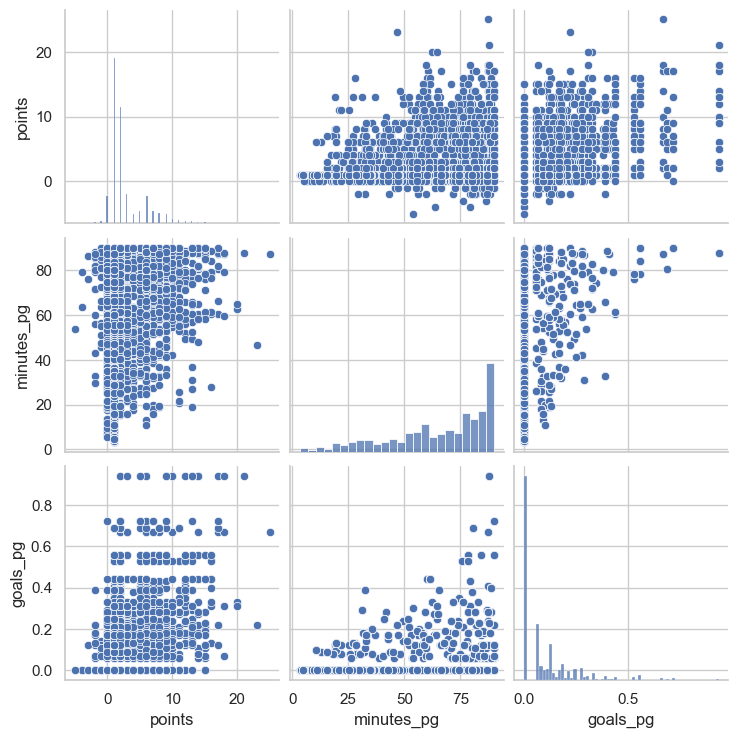

In [329]:
sns.pairplot(final_train_df[["points", "minutes_pg", "goals_pg"]])

Linear Regression Modelling

In [307]:
def linear_regression_modelling(train_df, test_df):
    """
    Function to fit a linear regression model to the training data and predict the points for the test data.

    Args:
        train_df (dataframe): A dataframe to train the model on
        test_df (dataframe): A dataframe to test the model on
    
    Returns:
        lr_model (model): A fitted linear regression model
        coefficients_df (dataframe): A dataframe with the coefficients of the model
        results_df (dataframe): A dataframe with the predicted points vs actual points for the training and test data
    """

    # split the data into features and target
    X_train = train_df.drop(columns=["points"]).copy()
    y_train = train_df["points"].copy()

    X_test = test_df.drop(columns=["points"]).copy()
    y_test = test_df["points"].copy()

    # scale the data
    scaler = StandardScaler()
    scaler_fitted = scaler.fit(X_train)
    X_train_scaled = scaler_fitted.transform(X_train)
    X_test_scaled = scaler_fitted.transform(X_test)

    # fit the model
    linear_regression = LinearRegression()
    lr_model = linear_regression.fit(X_train_scaled, y_train)

    # show the coefficients of the model
    coefficients_df = pd.DataFrame(data=lr_model.coef_, index=X_train.columns, columns=['Coefficient'])

    # predict the points
    y_pred_train = lr_model.predict(X_train_scaled)
    y_pred_test = lr_model.predict(X_test_scaled)

    # print the metrics
    print("Training Metrics:")
    print("Training R-Squared:", metrics.r2_score(y_train, y_pred_train))
    print("Training Mean Absolute Error:", metrics.mean_absolute_error(y_train, y_pred_train))
    print("Training Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)), "\n")

    print("Testing Metrics:")
    print("Testing R-Squared:", metrics.r2_score(y_test, y_pred_test))
    print("Testing Mean Absolute Error:", metrics.mean_absolute_error(y_test, y_pred_test))
    print("Testing Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))

    # create a DataFrame to return the predicted results vs. the actual
    results_df_train = pd.DataFrame({'GW' : train_df.index.get_level_values('GW'),
                              "name" : train_df.index.get_level_values('name'),
                              "position" : train_df.index.get_level_values('position'),
                              "team" : train_df.index.get_level_values('team'),
                              "opponent" : train_df.index.get_level_values('opponent'),
                              "points" : train_df['points'].values,
                              "predicted_points" : y_pred_train})
    results_df_train["residual"] = results_df_train["points"] - results_df_train["predicted_points"]
    results_df_train["dataset"] = "train"

    results_df_test = pd.DataFrame({'GW' : test_df.index.get_level_values('GW'),
                              "name" : test_df.index.get_level_values('name'),
                              "position" : test_df.index.get_level_values('position'),
                              "team" : test_df.index.get_level_values('team'),
                              "opponent" : test_df.index.get_level_values('opponent'),
                              "points" : test_df['points'].values,
                              "predicted_points" : y_pred_test})
    results_df_test["residual"] = results_df_test["points"] - results_df_test["predicted_points"]
    results_df_test["dataset"] = "test"

    results_df = pd.concat([results_df_train, results_df_test])

    return lr_model, coefficients_df, results_df

Goalkeeper Modelling

In [308]:
gk_lr_model, gk_coef_df, gk_model_df = linear_regression_modelling(df_gk_train, df_gk_test)
gk_model_df

Training Metrics:
Training R-Squared: 0.13230598756782508
Training Mean Absolute Error: 2.010644664152565
Training Root Mean Squared Error: 2.6022605137990276 

Testing Metrics:
Testing R-Squared: -0.23460506055636787
Testing Mean Absolute Error: 2.062141398815673
Testing Root Mean Squared Error: 2.525496666570576


,GW,name,position,team,opponent,points,predicted_points,residual,dataset
0,1,José Malheiro de Sá,GK,Wolves,Arsenal,2,2.057919,-0.057919,train
1,2,José Malheiro de Sá,GK,Wolves,Chelsea,-1,1.554886,-2.554886,train
2,8,José Malheiro de Sá,GK,Wolves,Man City,2,2.559305,-0.559305,train
3,9,José Malheiro de Sá,GK,Wolves,Brighton,2,2.357652,-0.357652,train
4,10,José Malheiro de Sá,GK,Wolves,Crystal Palace,2,3.777806,-1.777806,train
...,...,...,...,...,...,...,...,...,...
72,23,Robert Sánchez,GK,Chelsea,Man City,2,3.875483,-1.875483,test
73,21,Łukasz Fabiański,GK,West Ham,Fulham,1,2.510087,-1.510087,test
74,22,Łukasz Fabiański,GK,West Ham,Crystal Palace,2,4.114929,-2.114929,test
75,22,Ederson Santana de Moraes,GK,Man City,Ipswich,7,2.972223,4.027777,test


Defenders Model

In [309]:
def_lr_model, def_coef_df, def_model_df = linear_regression_modelling(df_def_train, df_def_test)
def_model_df

Training Metrics:
Training R-Squared: 0.1576916736583588
Training Mean Absolute Error: 1.890629357431807
Training Root Mean Squared Error: 2.527161676703371 

Testing Metrics:
Testing R-Squared: 0.095976436049236
Testing Mean Absolute Error: 1.9977544317695364
Testing Root Mean Squared Error: 2.6118119907352315


,GW,name,position,team,opponent,points,predicted_points,residual,dataset
0,1,Pau Torres,DEF,Aston Villa,West Ham,2,2.102138,-0.102138,train
1,2,Pau Torres,DEF,Aston Villa,Arsenal,1,1.289608,-0.289608,train
2,3,Pau Torres,DEF,Aston Villa,Leicester,2,1.980093,0.019907,train
3,4,Pau Torres,DEF,Aston Villa,Everton,1,2.827884,-1.827884,train
4,5,Pau Torres,DEF,Aston Villa,Wolves,1,1.918309,-0.918309,train
...,...,...,...,...,...,...,...,...,...
430,22,Axel Tuanzebe,DEF,Ipswich,Man City,1,1.458640,-0.458640,test
431,23,Axel Tuanzebe,DEF,Ipswich,Liverpool,0,0.707358,-0.707358,test
432,22,Cameron Burgess,DEF,Ipswich,Man City,-1,1.441568,-2.441568,test
433,23,Ben Mee,DEF,Brentford,Crystal Palace,1,2.174963,-1.174963,test


Midfielders Model

In [310]:
mid_lr_model, mid_coef_df, mid_model_df = linear_regression_modelling(df_mid_train, df_mid_test)
mid_model_df

Training Metrics:
Training R-Squared: 0.23854799355139722
Training Mean Absolute Error: 1.6588988367197497
Training Root Mean Squared Error: 2.5394082744288218 

Testing Metrics:
Testing R-Squared: 0.11383103268808714
Testing Mean Absolute Error: 1.863076701085429
Testing Root Mean Squared Error: 2.9346338354414314


,GW,name,position,team,opponent,points,predicted_points,residual,dataset
0,1,Alex Scott,MID,Bournemouth,Nott'm Forest,2,1.076590,0.923410,train
1,2,Alex Scott,MID,Bournemouth,Newcastle,1,1.124932,-0.124932,train
2,3,Alex Scott,MID,Bournemouth,Everton,1,1.474058,-0.474058,train
3,4,Alex Scott,MID,Bournemouth,Chelsea,1,1.009534,-0.009534,train
4,5,Alex Scott,MID,Bournemouth,Liverpool,1,0.824533,0.175467,train
...,...,...,...,...,...,...,...,...,...
677,22,Sander Berge,MID,Fulham,Leicester,3,2.371149,0.628851,test
678,23,Sander Berge,MID,Fulham,Man Utd,2,1.891116,0.108884,test
679,23,Marcus Tavernier,MID,Bournemouth,Nott'm Forest,7,2.890523,4.109477,test
680,23,Ryan Fraser,MID,Southampton,Newcastle,1,0.623910,0.376090,test


Forwards Model

In [311]:
fwd_lr_model, fwd_coef_df, fwd_model_df = linear_regression_modelling(df_fwd_train, df_fwd_test)
fwd_model_df

Training Metrics:
Training R-Squared: 0.20035979704986862
Training Mean Absolute Error: 2.341477045446551
Training Root Mean Squared Error: 3.1255594440200674 

Testing Metrics:
Testing R-Squared: 0.17482469333301343
Testing Mean Absolute Error: 2.547814921217952
Testing Root Mean Squared Error: 3.357435754116363


,GW,name,position,team,opponent,points,predicted_points,residual,dataset
0,1,Chris Wood,FWD,Nott'm Forest,Bournemouth,9,5.084073,3.915927,train
1,2,Chris Wood,FWD,Nott'm Forest,Southampton,1,5.908612,-4.908612,train
2,3,Chris Wood,FWD,Nott'm Forest,Wolves,9,5.741641,3.258359,train
3,4,Chris Wood,FWD,Nott'm Forest,Liverpool,2,3.980439,-1.980439,train
4,5,Chris Wood,FWD,Nott'm Forest,Brighton,8,5.317592,2.682408,train
...,...,...,...,...,...,...,...,...,...
158,23,Danny Welbeck,FWD,Brighton,Everton,2,4.769990,-2.769990,test
159,21,William Osula,FWD,Newcastle,Wolves,1,1.455816,-0.455816,test
160,22,William Osula,FWD,Newcastle,Bournemouth,1,0.798249,0.201751,test
161,22,Jhon Durán,FWD,Aston Villa,Arsenal,1,2.183002,-1.183002,test


In [312]:
# get a dataframe with all position model dataframes
all_model_dfs = pd.concat([gk_model_df, def_model_df, mid_model_df, fwd_model_df]).reset_index(drop=True)
all_model_dfs

,GW,name,position,team,opponent,points,predicted_points,residual,dataset
0,1,José Malheiro de Sá,GK,Wolves,Arsenal,2,2.057919,-0.057919,train
1,2,José Malheiro de Sá,GK,Wolves,Chelsea,-1,1.554886,-2.554886,train
2,8,José Malheiro de Sá,GK,Wolves,Man City,2,2.559305,-0.559305,train
3,9,José Malheiro de Sá,GK,Wolves,Brighton,2,2.357652,-0.357652,train
4,10,José Malheiro de Sá,GK,Wolves,Crystal Palace,2,3.777806,-1.777806,train
...,...,...,...,...,...,...,...,...,...
6590,23,Danny Welbeck,FWD,Brighton,Everton,2,4.769990,-2.769990,test
6591,21,William Osula,FWD,Newcastle,Wolves,1,1.455816,-0.455816,test
6592,22,William Osula,FWD,Newcastle,Bournemouth,1,0.798249,0.201751,test
6593,22,Jhon Durán,FWD,Aston Villa,Arsenal,1,2.183002,-1.183002,test


My initial linear regression model showed a low R-squared value and relatively high error, which suggests the model isn't capturing the complexity of the data. This is likely due to non-linear relationships between features and the target variable that linear regression cannot model effectively. To improve prediction accuracy, I plan to explore more advanced models such as Random Forest or Gradient Boosting, which are better at capturing non-linear patterns. Since prediction is the main objective, I will also continue using highly correlated features if they help improve performance, even though they might reduce model interpretability.

Investigate Model Assumptions

Model Assumption: Normality

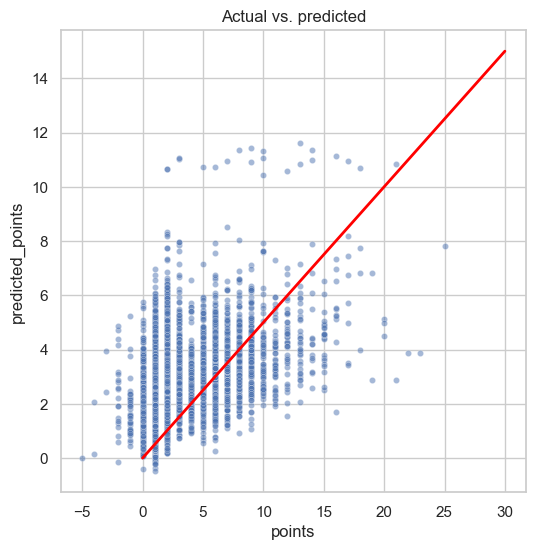

In [221]:
# Create a scatterplot to visualize `predicted` over `actual`
fig, ax = plt.subplots(figsize=(6, 6))
sns.set(style='whitegrid')
sns.scatterplot(x='points',
                y='predicted_points',
                data=all_model_dfs,
                s=20,
                alpha=0.5,
                ax=ax
)
# Draw an x=y line to show what the results would be if the model were perfect
plt.plot([0,30], [0,15], c='red', linewidth=2)
plt.title('Actual vs. predicted');

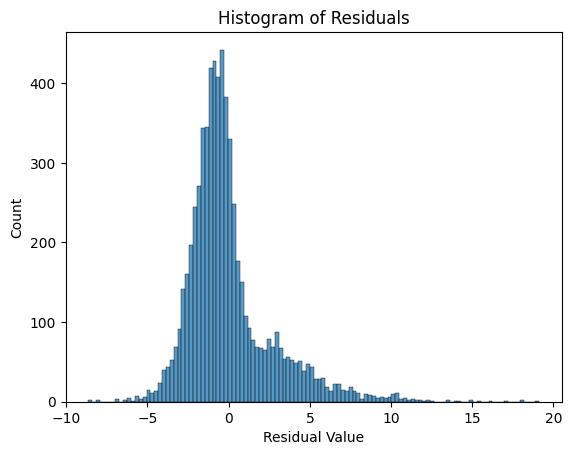

In [104]:
# Visualise the distribution of the residuals
fig = sns.histplot(all_model_dfs["residual"])
fig.set_xlabel("Residual Value")
fig.set_title("Histogram of Residuals")
plt.show()

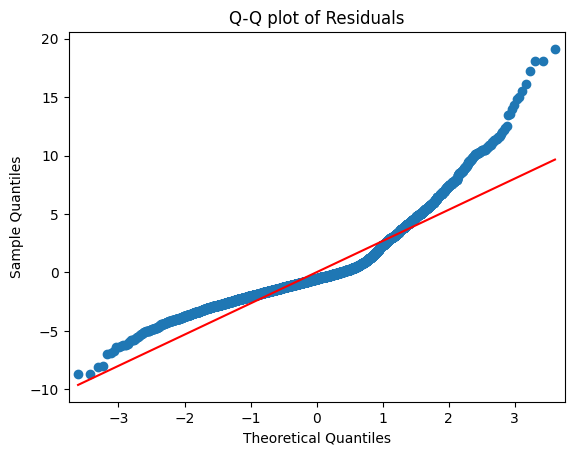

In [105]:
# Create a Q-Q plot to check the normality of the residuals
sm.qqplot(all_model_dfs["residual"], line='s')
plt.title("Q-Q plot of Residuals")
plt.show()

Model Assumption: Constant Variance

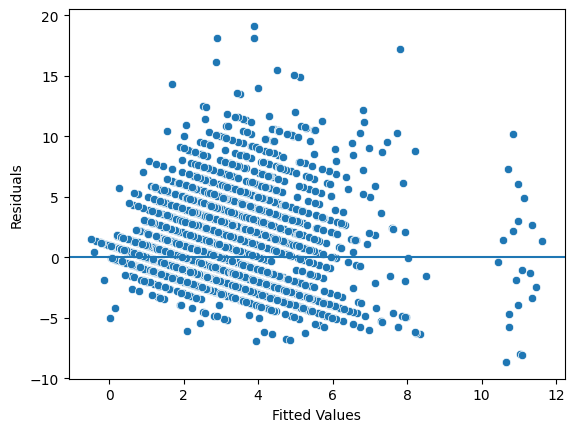

In [ ]:
# Create a scatterplot of residuals against fitted values

fig = sns.scatterplot(x=all_model_dfs["predicted_points"], y=all_model_dfs["residual"])
fig.set_xlabel("Fitted Values")
fig.set_ylabel("Residuals")
fig.set_title("Fitted Values v. Residuals")
fig.axhline(0)
plt.show()

Get future fixtures and make predictions for predicted points, and then rank who will have the most predicted points till the end of the season or something